In [1]:
import pandas as pd
import hopsworks
import os
import warnings
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score
from tqdm import tqdm_notebook as tqdm
from Bird_percent import *
from dataclasses import dataclass

In [2]:
warnings.filterwarnings("ignore")
from dotenv import load_dotenv
load_dotenv()

HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
project = hopsworks.login(project="BirdUp", api_key_value=HOPSWORKS_API_KEY)

2025-12-21 12:13:30,217 INFO: Initializing external client
2025-12-21 12:13:30,218 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-12-21 12:13:32,614 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1327256


In [3]:
## Feature Transforms
# get the df locally from hopsworks

@dataclass
class DataSet:
    train: pd.DataFrame
    val: pd.DataFrame
    test: pd.DataFrame

    @property
    def train_tensor(self) -> torch.Tensor:
        return torch.tensor(self.train.to_numpy(), dtype=torch.float32)

    @property
    def val_tensor(self) -> torch.Tensor:
        return torch.tensor(self.val.to_numpy(), dtype=torch.float32)

    @property
    def test_tensor(self) -> torch.Tensor:
        return torch.tensor(self.test.to_numpy(), dtype=torch.float32)


def get_feature_group_as_df(feature_group_name: str = "birding", feature_group_version: int = 1):
    fs = project.get_feature_store()
    fg = fs.get_feature_group(
        name=feature_group_name, version=feature_group_version
    )
    df = fg.read()
    return df

def sort_by_date(df:pd.DataFrame, date_col:str='observation_date'):
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(by=date_col).reset_index(drop=True)
    return df

def true_false_to_01(df:pd.DataFrame):
    # Vectorized conversion is significantly faster than lambda mapping
    return df.astype({col: int for col in df.select_dtypes(include='bool').columns})

def encode_reigon(df:pd.DataFrame, region_col:str='region'):
    # calculate means based on observation_count
    region_means = df.groupby(region_col)['observation_count'].mean().sort_values()
    
    # map to ordinal integers based on rank (0 = lowest avg count, 24 = highest)
    region_mapping = {region: i for i, region in enumerate(region_means.index)}
    df[region_col] = df[region_col].map(region_mapping)
    
    return df, region_mapping

def drop_unused_columns(df:pd.DataFrame):
    unused_cols = ["observation_date", "time_observations_started", "weathercode", "obs_count_lag_1", "obs_count_lag_2", "obs_count_lag_3", "obs_count_lag_4", "obs_count_lag_5"]
    df = df.drop(columns=unused_cols)
    return df

def birdcount_binarization(df:pd.DataFrame):
    df['bird_count_binary'] = (df['observation_count'] > 0).astype(int)
    df = df.drop(columns=['observation_count'])
    return df

def split_data(df:pd.DataFrame, train_size:float=0.8, val_size:float=0.1, shuffle = True) -> dict[str, DataSet]:
    # ------Helper function -----
    def show_dataset_end_dates(data_dict: dict):
        for bird, ds in data_dict.items():
            print(f"Bird: {bird}")
            # Check train, val, and test splits
            for split_name in ['train', 'val', 'test']:
                df = getattr(ds, split_name)
                
                if 'observation_date' in df.columns:
                    end_val = int(df['observation_date'].max()) 
                elif 'year' in df.columns:
                    # Fallback if date was dropped but year remains
                    end_val = f"Year: {df['year'].max()}"
                else:
                    end_val = "Date column not found"
                    
                print(f"  {split_name.capitalize()} End: {end_val}")

    # ---- Main function body ----            
    if shuffle:
        df = df.sample(frac=1, random_state=42).reset_index(drop=True)
    unique_birds=df["bird_type"].unique()
    # make dict with the keys train, val, test and empty dataframes as values
    ret_dict = {}
    for bird in unique_birds:
        bird_df = df[df["bird_type"]==bird]
        bird_df = bird_df.drop(columns=["bird_type"]).reset_index(drop=True)
        n = bird_df.shape[0]
        train_end = int(n * train_size)
        val_end = int(n * (train_size + val_size))
        
        bird_df_train = bird_df.iloc[:train_end]
        bird_df_val = bird_df.iloc[train_end:val_end]
        bird_df_test = bird_df.iloc[val_end:]
        
        ret_dict[bird] = DataSet(train=bird_df_train, val=bird_df_val, test=bird_df_test)
    if not shuffle:
        print("Dataset end dates (no shuffle):")
        show_dataset_end_dates(ret_dict)
    return ret_dict

def drop_x_negative_samples(df, drop_percentage=0.2):
    """
    Here we downsample the negative samples (bird_count_binary == 0) by a given percentage.
    This helps to balance the dataset, we have a large number of negative samples compared to positive ones.
    """
    neg = df[(df['bird_count_binary'] == 0)]
    pos = df[~((df['bird_count_binary'] == 0))]
    
    # Calculate number of samples to drop
    num_to_drop = int(len(neg) * drop_percentage)
    
    # Randomly sample the indices to keep
    neg_downsampled = neg.sample(n=len(neg) - num_to_drop, random_state=42)
    
    # Combine back and shuffle
    new_df = pd.concat([pos, neg_downsampled]).sample(frac=1, random_state=42).reset_index(drop=True)
    
    return new_df

In [4]:
hops_df = get_feature_group_as_df()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (4.01s) 


In [5]:
print("Len hopsworks ds",hops_df.shape[0])
hops_df = true_false_to_01(hops_df)
hops_df = sort_by_date(hops_df)
hops_df, REGION_MAPPING = encode_reigon(hops_df)
hops_df = drop_unused_columns(hops_df)
hops_df = birdcount_binarization(hops_df)

Len hopsworks ds 273350


In [11]:
print(REGION_MAPPING)

{'Dalsland': 0, 'Ångermanland': 1, 'Medelpad': 2, 'Jämtland': 3, 'Härjedalen': 4, 'Bohuslän': 5, 'Hälsingland': 6, 'Dalarna': 7, 'Norrbotten': 8, 'Blekinge': 9, 'Lappland': 10, 'Värmland': 11, 'Västmanland': 12, 'Gästrikland': 13, 'Småland': 14, 'Östergötland': 15, 'Närke': 16, 'Västerbotten': 17, 'Gotland': 18, 'Västergötland': 19, 'Halland': 20, 'Uppland': 21, 'Öland': 22, 'Södermanland': 23, 'Skåne': 24}


In [6]:
hops_df

,region,wind,rain,temperature,bird_type,year,month_1,month_2,month_3,month_4,...,month_9,month_10,month_11,month_12,sighted_lag_1,sighted_lag_2,sighted_lag_3,sighted_lag_4,sighted_lag_5,bird_count_binary
0,8,3.9,0.9,-16.6,whteag,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,14.1,3.4,-5.9,whteag,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,13,16.3,6.3,-3.6,goleag,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,19,20.7,0.5,-1.1,goleag,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2,14.1,3.4,-5.9,goleag,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
273345,14,16.8,0.1,6.4,whteag,14,0,0,0,0,...,0,0,0,1,1,0,1,0,0,0
273346,21,18.9,4.7,6.4,goleag,14,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
273347,7,18.9,4.0,4.5,whteag,14,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
273348,23,16.2,2.7,6.5,goleag,14,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [7]:
data = split_data(hops_df)
print(data["whteag"].train_tensor.shape)

torch.Size([109340, 23])


### Model training

In [8]:
# i try to rebalance the goleag dataset by downsampling the negative samples by 20% of training data
print(data["goleag"].train.shape)
data["goleag"].train = drop_x_negative_samples(data["goleag"].train, drop_percentage=0.2)
print(data["goleag"].train.shape)

g_train_x = data["goleag"].train_tensor[:, :-1].to(device)
g_train_y = data["goleag"].train_tensor[:, -1].to(device)

g_val_x = data["goleag"].val_tensor[:, :-1].to(device)
g_val_y = data["goleag"].val_tensor[:, -1].to(device)


w_train_x = data["whteag"].train_tensor[:, :-1].to(device)
w_train_y = data["whteag"].train_tensor[:, -1].to(device)
w_val_x = data["whteag"].val_tensor[:, :-1].to(device)
w_val_y = data["whteag"].val_tensor[:, -1].to(device)

(109340, 23)
(87681, 23)


In [9]:
params = {
    'num_epochs': [5000, 6000],
    'learning_rate': [0.01, 0.05],
    'hidden_layers': [[64, 32, 1], [32, 16, 1]] 
}
#best_hparams, best_state = grid_search(g_train_x, g_train_y, g_val_x, g_val_y, params)

**White ag:**

Best Balanced Accuracy: 0.6846 
Best Params: {'num_epochs': 10000, 'learning_rate': 0.01, 'hidden_layers': [64, 32, 1]}


**Gold ag:**

Best Balanced Accuracy: 0.5110
Best Params: {'num_epochs': 6000, 'learning_rate': 0.01, 'hidden_layers': [32, 16, 1]}

In [10]:

goldag_model = BirdPercentModel(in_features=g_train_x.shape[1], hidden_layers=[32, 16, 1]).to(device=device)
goldag_model  = train_model(g_train_x, g_train_y, g_val_x, g_val_y, goldag_model, num_epochs=6000, learning_rate=0.01, val=False)

whteag_model = BirdPercentModel(in_features=w_train_x.shape[1], hidden_layers=[64, 32, 1]).to(device=device)
whteag_model  = train_model(w_train_x, w_train_y, w_val_x, w_val_y, whteag_model, num_epochs=10000, learning_rate=0.01, val=False)


  0%|          | 0/6000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:

# now we find the oprimal sigm for both models
best_sigm_goleag, best_bal_acc_goleag = optim_signmoid_search(g_val_x, g_val_y, goldag_model)
print(f"Best sigm for Goleag: {best_sigm_goleag}, with balanced accuracy: {best_bal_acc_goleag:.4f}")
best_sigm_whteag, best_bal_acc_whteag = optim_signmoid_search(w_val_x, w_val_y, whteag_model)
print(f"Best sigm for Whteag: {best_sigm_whteag}, with balanced accuracy: {best_bal_acc_whteag:.4f}")

Best sigm for Goleag: 0.015789473684210527, with balanced accuracy: 0.6645
Best sigm for Whteag: 0.07894736842105263, with balanced accuracy: 0.8093


Goleag Test Set Evaluation:
F1-Score: 0.0703


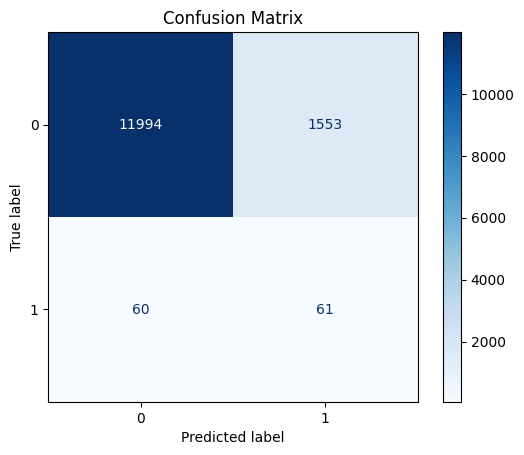

Balanced Accuracy on Goleag Test Set: 0.6947
Whteag Test Set Evaluation:
F1-Score: 0.4502


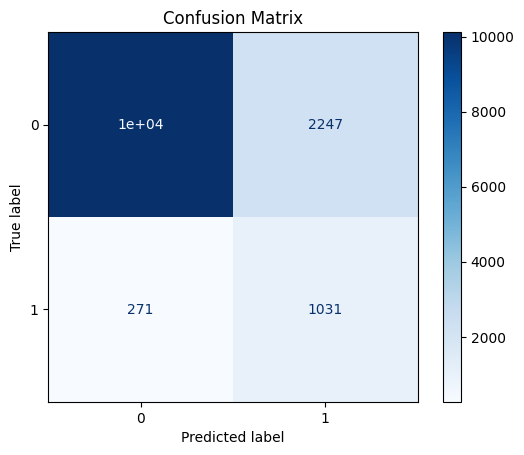

Balanced Accuracy on Whteag Test Set: 0.8051


In [ ]:
# we try on the test set now
g_test_x = data["goleag"].test_tensor[:, :-1].to(device)
g_test_y = data["goleag"].test_tensor[:, -1].to(device)
w_test_x = data["whteag"].test_tensor[:, :-1].to(device)
w_test_y = data["whteag"].test_tensor[:, -1].to(device)

goldag_model.eval()
with torch.no_grad():
    test_outputs_goleag = goldag_model(g_test_x)
    preds_goleag = (test_outputs_goleag.cpu().numpy() > best_sigm_goleag).astype(int)
    truths_goleag = g_test_y.cpu().numpy().astype(int)
    print("Goleag Test Set Evaluation:")
    bal_acc = evaluate(preds_goleag, truths_goleag, cm=True, fOne=True)
    print(f"Balanced Accuracy on Goleag Test Set: {bal_acc:.4f}")

whteag_model.eval()
with torch.no_grad():
    test_outputs_whteag = whteag_model(w_test_x)
    preds_whteag = (test_outputs_whteag.cpu().numpy() > best_sigm_whteag).astype(int)
    truths_whteag = w_test_y.cpu().numpy().astype(int)
    print("Whteag Test Set Evaluation:")
    bal_acc = evaluate(preds_whteag, truths_whteag, cm=True, fOne=True)
    print(f"Balanced Accuracy on Whteag Test Set: {bal_acc:.4f}")



### Hopsworks 

Here we uppload the models to hopsworks 

In [ ]:
g_dir = "./goldag_model"
w_dir = "./whteag_model"


torch.save(goldag_model.state_dict(), g_dir)
torch.save(whteag_model.state_dict(), w_dir)

In [ ]:
metric_goldag = {"F1-Score": 0.0703, "Balanced_Acc": 0.6947, "Best_Signmoid": best_sigm_goleag}
metric_whteag = {"F1-Score": 0.4502, "Balanced_Acc": 0.8051, "Best_Signmoid": best_sigm_whteag}

In [ ]:
mr = project.get_model_registry()

hops_goldag_model  = mr.torch.create_model("Goleag_model", metrics=metric_goldag)
hops_whteag_model  = mr.torch.create_model("Whteag_model", metrics=metric_whteag)

In [ ]:
hops_goldag_model.save(g_dir)
hops_whteag_model.save(w_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/jarlstephansson/Desktop/ID2223/Project/BirdUp/Models/./goldag_model: 0.000%|          | 0/820…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1327256/models/Goleag_model/1


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/jarlstephansson/Desktop/ID2223/Project/BirdUp/Models/./whteag_model: 0.000%|          | 0/174…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1327256/models/Whteag_model/1


Model(name: 'Whteag_model', version: 1)

## Try to download the model again: 

In [ ]:
# 1. Access the Model Registry
mr = project.get_model_registry()

# 2. Retrieve model metadata from Hopsworks (e.g., version 1)
hops_goldag_meta = mr.get_model("Goleag_model", version=1)
hops_whteag_meta = mr.get_model("Whteag_model", version=1)

# 3. Download the model files to a local directory
g_path = hops_goldag_meta.download()
w_path = hops_whteag_meta.download()

# 4. Re-initialize your model classes (ensure in_features matches your training data)
goldag_model_loaded = BirdPercentModel(in_features=g_train_x.shape[1], hidden_layers=[32, 16, 1])
whteag_model_loaded = BirdPercentModel(in_features=w_train_x.shape[1], hidden_layers=[64, 32, 1])

# 5. Load the state dicts using the downloaded paths
# Note: Hopsworks download() returns the directory path containing the file
goldag_model_loaded.load_state_dict(torch.load(f"{g_path}/goldag_model"))
whteag_model_loaded.load_state_dict(torch.load(f"{w_path}/whteag_model"))

# 6. Set to evaluation mode
goldag_model_loaded.eval()
whteag_model_loaded.eval()

Downloading: 0.000%|          | 0/8209 elapsed<00:00 remaining<?

Downloading: 0.000%|          | 0/17425 elapsed<00:00 remaining<?

BirdPercentModel(
  (stack): ModuleList(
    (0): Linear(in_features=22, out_features=64, bias=True)
    (1): Linear(in_features=64, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)